# Node2vec model using torch Geometric with Cora

In [16]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [17]:
path = '/Users/kasidej/Documents/study/gnn/' # directory to download the dataset
dataset = Planetoid(path, "Cora")
data = dataset[0] # tensor representation of cora-planetoid data
print('Cora: ', data)

Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [18]:
# Construct the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
node2vec_model = Node2Vec(data.edge_index, embedding_dim = 128, walk_length = 20, context_size = 10, 
                            walks_per_node = 10, num_negative_samples = 1, p = 1, q = 1, sparse = True).to(device)
loader = node2vec_model.loader(batch_size = 128, shuffle=True, num_workers = 4) # num_workers = number of cores
optimizer = torch.optim.SparseAdam(list(node2vec_model.parameters()), # list of parameters
                                    lr = 0.01) # learning rate

In [19]:
# Train function
def train():
    node2vec_model.train() # set training as true for the model
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec_model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss =+ loss.item()
    return total_loss / len(loader)

# plot the embedding
def plot_point(colors):
    node2vec_model.eval()
    with torch.inference_model():
        z = node2vec_model(torch.arange(data.num_nodes, device=device))
        z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
        y = data.y.cpu().numpy()
        plt.figure()
        for i in range(dataset.num_classes):
            plt.scatter(z[y==i, 0], z[y==i, 1], s=20, color = colors[i])
        plt.axis('off')
        plt.show()


In [20]:
# Get embedding
for epoch in range(1,101):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 0.3250
Epoch: 02, Loss: 0.2421
Epoch: 03, Loss: 0.2130
Epoch: 04, Loss: 0.1787
Epoch: 05, Loss: 0.1495
Epoch: 06, Loss: 0.1256
Epoch: 07, Loss: 0.1100
Epoch: 08, Loss: 0.0960
Epoch: 09, Loss: 0.0842
Epoch: 10, Loss: 0.0782
Epoch: 11, Loss: 0.0690
Epoch: 12, Loss: 0.0620
Epoch: 13, Loss: 0.0590
Epoch: 14, Loss: 0.0535
Epoch: 15, Loss: 0.0520
Epoch: 16, Loss: 0.0496
Epoch: 17, Loss: 0.0478
Epoch: 18, Loss: 0.0466
Epoch: 19, Loss: 0.0450
Epoch: 20, Loss: 0.0444
Epoch: 21, Loss: 0.0440
Epoch: 22, Loss: 0.0422
Epoch: 23, Loss: 0.0419
Epoch: 24, Loss: 0.0407
Epoch: 25, Loss: 0.0411
Epoch: 26, Loss: 0.0408
Epoch: 27, Loss: 0.0412
Epoch: 28, Loss: 0.0400
Epoch: 29, Loss: 0.0393
Epoch: 30, Loss: 0.0391
Epoch: 31, Loss: 0.0385
Epoch: 32, Loss: 0.0397
Epoch: 33, Loss: 0.0392
Epoch: 34, Loss: 0.0389
Epoch: 35, Loss: 0.0385
Epoch: 36, Loss: 0.0393
Epoch: 37, Loss: 0.0383
Epoch: 38, Loss: 0.0389
Epoch: 39, Loss: 0.0386
Epoch: 40, Loss: 0.0384
Epoch: 41, Loss: 0.0386
Epoch: 42, Loss:

/opt/homebrew/Caskroom/miniforge/base/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


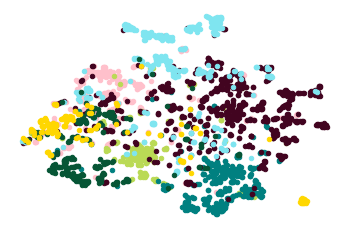

In [21]:
# plot 2D embedding
colors = [
        '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
        '#ffd700'
    ]
plot_point(colors)

In [23]:
# classification
# link: https://github.com/pyg-team/pytorch_geometric/blob/master/torch_geometric/nn/models/node2vec.py

def test():
    node2vec_model.eval() # Evaluate the model based on the trained parameters
    z = node2vec_model() # Evaluate the model based on the trained parameters

    # logistic regression
    acc = node2vec_model.test(z[data.train_mask] ,data.y[data.train_mask],
                              z[data.test_mask],data.y[data.test_mask],
                              max_iter=150)
    return acc

print('Accuracy:', test())


Accuracy: 0.714
